In [5]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

from sympy.solvers import solve
from sympy import Symbol
import numpy as np
import pandas as pd
import cmath

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [6]:
epsilon = 10e-5

def CGUpdate(xk, deriv1_xk, Q, dk):
    """
        xk:        Current value 
        deriv1_xk: First order derivative of function f(xk)
        Q :        Q formed when we convert the function in standard form
                   Also equivallent to Hessian matrix, Computation is needed only once
                   No update is required
        
        pk (Search direction) = - inv(Bk).deriv1_xk 
    """
    alpha = -1 * np.dot(np.transpose(dk), deriv1_xk) / np.dot(np.dot(np.transpose(dk), Q), dk)
    xk1 = xk + alpha*dk
    return xk1, alpha

def updateCG(step, deriv_1, xk1, gradient_xk, Q, dk, numVariables):
    """
        step:             Step Num, int
        deriv_1           1st order derivative of the input function 
        xk1:              New Solution
        gradient_xk:      deriv_1 evaluated at xk1
    """
    if numVariables == 3:
        gradient_xk1 =  np.array([eq.evalf(subs={x1:xk1[0], x2:xk1[1], x3:xk1[2]}) 
                                  for eq in deriv_1], dtype='float32').reshape(3,1)
        dk = dk.reshape(3,1)
    
    elif numVariables == 2:
        gradient_xk1 =  np.array([eq.evalf(subs={x1:xk1[0], x2:xk1[1]}) 
                                  for eq in deriv_1], dtype='float32').reshape(2,1)
        dk = dk.reshape(2,1)
    else:
        raise ValueError('Num Features doesnt match the handled conditions')

    cmn = np.dot(dk.T, Q)
    numerator = np.dot(cmn,gradient_xk1)
    denominator = np.dot(cmn,dk)
    beta = numerator/denominator

    dk1 = -1 * gradient_xk1 + beta*dk
    print ('Check if the vector d is Q conjugate or not', np.dot(np.dot(dk1.T, Q), dk))

    return dk1


def iterate(f, xk, deriv_1, Q, numFeatures, numSteps, should_print, evalQ=True):
    fx_arr = []
    gradientNorm_arr = []
    alpha_arr = []
    xk1_arr = []
    for step in range(numSteps):
        if numFeatures == 3:
            fx = f.evalf(subs={x1:xk[0], x2:xk[1], x3:xk[2]})
            gradient_xk = np.array([eq.evalf(subs={x1:xk[0], x2:xk[1], x3:xk[2]}) for eq in deriv_1], 
                                   dtype='float32')
            if evalQ:
                Q_lv = np.array([cell.evalf(subs={x1:xk[0], x2:xk[1], x3:xk[2]}) for row in Q for cell in row], 
                                   dtype='float32').reshape(3,3)
            else:
                Q_lv = Q
        elif numFeatures == 2:
            fx = f.evalf(subs={x1:xk[0], x2:xk[1]})
            gradient_xk = np.array([eq.evalf(subs={x1:xk[0], x2:xk[1]}) for eq in deriv_1], 
                                   dtype='float32')
            if evalQ:
                Q_lv = np.array([cell.evalf(subs={x1:xk[0], x2:xk[1]}) for row in Q for cell in row], 
                                   dtype='float32').reshape(2,2)
            else:
                Q_lv = Q
        else:
            raise ValueError('Num Features doesnt match the hadled condition')
        
        fx_arr.append(fx)
        gradientNorm = np.linalg.norm(gradient_xk)
        gradientNorm_arr.append(gradientNorm)
        
        if step == 0:
            dk = -1*gradient_xk
            dk = dk.reshape(len(dk),1)
            
        if should_print:
            if (step+1)%should_print == 0:
                print('')
                print ('##########################################################')
                print ('Function F at x: f(x) ', fx)
                print ('Gradient at xk%s is: '%str(step), gradient_xk)
                print ("####### Gradient Norm: ", gradientNorm)
                print('The updated Value dk%s is \n'%(step+1), dk)
                print('The updated Value xk%s is \n'%(step+1), xk)
                
        if np.sum((gradientNorm/(1+np.abs(gradient_xk))) <= epsilon) == len(gradient_xk) or (step == 1000):
            print('The check (gradient norm equation reach a val < epsilon, HENCE BREAKING OUT OF LOOP)')
            break
            
        xk1, alpha = CGUpdate(xk=xk, deriv1_xk=gradient_xk, Q=Q_lv, dk=dk)
        dk1 = updateCG(step+1, deriv_1, xk1, gradient_xk, Q_lv, dk, numFeatures)
        
        # Parameter UPdate
        xk = xk1
        dk = dk1
        
        alpha_arr.append(alpha)
        xk1_arr.append(xk1)
        
    return fx_arr, gradientNorm_arr, alpha_arr, xk1_arr


def plot(subplotArr, rows=1, columns=2, figsize=(10, 3), contour=False):
    fig1, axs = plt.subplots(rows,columns, figsize=figsize, facecolor='w', edgecolor='k')
    if columns>1:
        axs = axs.ravel()
    for no, arrVal in enumerate(subplotArr):
        if no == 0 and contour:
            x1 = subplotArr[0]["x1"]
            x2 = subplotArr[0]['x2']
            z = subplotArr[0]['z']
            sol_x1 = subplotArr[0]['sol_x1']
            sol_x2 = subplotArr[0]['sol_x2']
            axs[no].contourf(x1,x2,z)
            axs[no].plot(sol_x1, sol_x2, 'r')
            axs[no].set_title('Contour Plot for the function')
        elif no == 0 and not contour:
            axs[no].plot(np.arange(len(subplotArr[0]["functionVal"])), subplotArr[0]["functionVal"])
            axs[no].set_xlabel('num of Iteration')
            axs[no].set_ylabel('Function f(x) at step')
            axs[no].set_title('Function Vs Num Iteration')
        else:
            axs[no].plot(np.arange(len(subplotArr[1]["gradientNorm"])), subplotArr[1]["gradientNorm"])
#             axs[no].plot(np.arange(len(arrVal)), arrVal)
            axs[no].set_xlabel('num of Iteration')
            axs[no].set_ylabel('Gradient Norm at step')
            axs[no].set_title('Gradient Norm Vs Num Iteration')
            
    plt.show()        

# Solution d(1)

First order Derivative:  [2*x1 2*x2 2*x3]
Q: 
 [[2 0 0]
 [0 2 0]
 [0 0 2]]

##########################################################
Function F at x: f(x)  3.00000000000000
Gradient at xk0 is:  [ 2.  2.  2.]
####### Gradient Norm:  3.4641
The updated Value dk1 is 
 [[-2.]
 [-2.]
 [-2.]]
The updated Value xk1 is 
 [[ 1.]
 [ 1.]
 [ 1.]]
Check if the vector d is Q conjugate or not [[ 0.]]

##########################################################
Function F at x: f(x)  0.e-125
Gradient at xk1 is:  [ 0.  0.  0.]
####### Gradient Norm:  0.0
The updated Value dk2 is 
 [[-0.]
 [-0.]
 [-0.]]
The updated Value xk2 is 
 [[ 0.]
 [ 0.]
 [ 0.]]
The check (gradient norm equation reach a val < epsilon, HENCE BREAKING OUT OF LOOP)


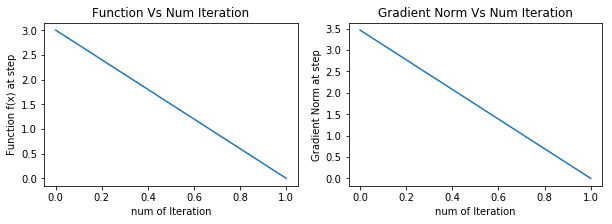

,alpha,xk
0,[[0.5]],"[[0.0], [0.0], [0.0]]"


In [7]:
x1 = Symbol('x1')
x2 = Symbol('x2')
x3 = Symbol('x3')

f = pow(x1,2) + pow(x2,2) + pow(x3,2)
deriv_1 = np.array([f.diff(x1), f.diff(x2), f.diff(x3)])
print ('First order Derivative: ', deriv_1)
Q = np.array([[2,0,0],[0,2,0],[0,0,2]])  # Q is obtained by converting the funciton into quadratic form, which is equivallent to 2nd order derivative in all our case
print ('Q: \n', Q)

# Initialize Xk
xk = np.array([1,1,1], dtype=float).reshape(3,1)

fx_array, gradientNorm_arr, alpha_arr, xk1_arr= iterate(f, xk, deriv_1, Q,
                                                 numFeatures=3, numSteps=10, 
                                                 should_print=1,evalQ=False)

outData = pd.DataFrame(columns=["alpha","xk"])
outData["alpha"] = alpha_arr
outData["xk"] = xk1_arr

plot([dict(functionVal = fx_array), dict(gradientNorm = gradientNorm_arr)])

outData

# Solution d(2)

Q: 
 [[ 2. -2.]
 [-2.  4.]]

##########################################################
Function F at x: f(x)  0.e-125
Gradient at xk0 is:  [ 0. -2.]
####### Gradient Norm:  2.0
The updated Value dk1 is 
 [[-0.]
 [ 2.]]
The updated Value xk1 is 
 [[ 0.]
 [ 0.]]
Check if the vector d is Q conjugate or not [[ 0.]]

##########################################################
Function F at x: f(x)  -0.500000000000000
Gradient at xk1 is:  [-1.  0.]
####### Gradient Norm:  1.0
The updated Value dk2 is 
 [[ 1. ]
 [ 0.5]]
The updated Value xk2 is 
 [[ 0. ]
 [ 0.5]]
Check if the vector d is Q conjugate or not [[ 0.]]

##########################################################
Function F at x: f(x)  -1.00000000000000
Gradient at xk2 is:  [ 0.  0.]
####### Gradient Norm:  0.0
The updated Value dk3 is 
 [[ 0.]
 [ 0.]]
The updated Value xk3 is 
 [[ 1.]
 [ 1.]]
The check (gradient norm equation reach a val < epsilon, HENCE BREAKING OUT OF LOOP)


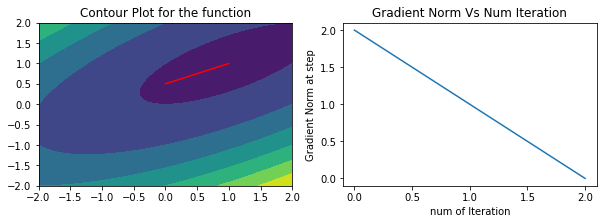

,alpha,xk
0,[[0.25]],"[[0.0], [0.5]]"
1,[[1.0]],"[[1.0], [1.0]]"


In [8]:
x1 = Symbol('x1')
x2 = Symbol('x2')
f = pow(x1,2) + 2*pow(x2,2) - 2*x1*x2 - 2*x2
deriv_1 = np.array([f.diff(x1), f.diff(x2)])
Q = np.array([[deriv_1[0].diff(x1),deriv_1[0].diff(x2)],
              [deriv_1[1].diff(x1),deriv_1[1].diff(x2)]], dtype=float)
print ('Q: \n', Q)

# Initialize Xk
xk = np.array([0,0], dtype=float).reshape(2,1)

fx_array, gradientNorm_arr, alpha_arr, xk1_arr= iterate(f, xk, deriv_1, Q,
                                                 numFeatures=2, numSteps=10, should_print=1,evalQ=False)

outData = pd.DataFrame(columns=["alpha","xk"])
outData["alpha"] = alpha_arr
outData["xk"] = xk1_arr

###########  Plot  ###########
x1_x2 = np.asarray(xk1_arr)
u = np.linspace(-2,2,5000)
x1,x2 = np.meshgrid(u,u)
z = pow(x1,2) + 2*pow(x2,2) - 2*x1*x2 - 2*x2
plot([dict(x1=x1, x2=x2, z=z, sol_x1=x1_x2[:,0], sol_x2=x1_x2[:,1]), dict(gradientNorm = gradientNorm_arr)], contour=True)

outData

# Solution d(3)

Check if the vector d is Q conjugate or not [[-0.2046814]]
Check if the vector d is Q conjugate or not [[  3.05175781e-05]]
Check if the vector d is Q conjugate or not [[ 0.375]]
Check if the vector d is Q conjugate or not [[ 0.1484375]]
Check if the vector d is Q conjugate or not [[ 0.0625]]
Check if the vector d is Q conjugate or not [[ 0.0625]]
Check if the vector d is Q conjugate or not [[ 0.]]
Check if the vector d is Q conjugate or not [[ 0.00244141]]
Check if the vector d is Q conjugate or not [[ 0.]]

##########################################################
Function F at x: f(x)  2.12738004992937
Gradient at xk9 is:  [ -8.81486893 -16.83890533]
####### Gradient Norm:  19.0066
The updated Value dk10 is 
 [[ -0.73807526]
 [ 25.16270828]]
The updated Value xk10 is 
 [[-0.19101141]
 [-0.04770917]]
Check if the vector d is Q conjugate or not [[ -6.10351562e-05]]
Check if the vector d is Q conjugate or not [[ 0.]]
Check if the vector d is Q conjugate or not [[-1.203125]]
Check if t

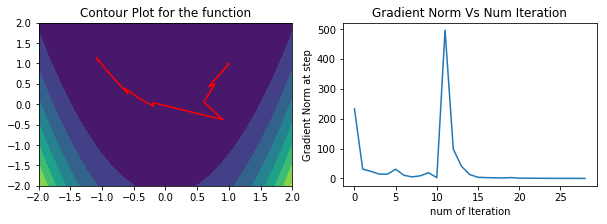

,alpha,xk
0,[[0.000664669]],"[[-1.05669744015], [1.05849083886]]"
1,[[-1.12816]],"[[-1.0862824142], [1.13887314126]]"
2,[[0.00231674]],"[[-0.892080423236], [0.769062828273]]"
3,[[2.20758e-05]],"[[-0.893188440753], [0.771851120982]]"
4,[[0.00655466]],"[[-0.588809633208], [0.255179165397]]"
5,[[0.000710999]],"[[-0.643429910345], [0.390758080874]]"
6,[[0.00959803]],"[[-0.460681935353], [0.202591104899]]"
7,[[-0.00170122]],"[[-0.436550110159], [0.166236995254]]"
8,[[0.0099978]],"[[-0.191011413513], [-0.0477091684006]]"
9,[[0.00336919]],"[[-0.193498132098], [0.0370688722469]]"


In [9]:
x1 = Symbol('x1')
x2 = Symbol('x2')
f = (-x1 + 1)**2 + 100*(-x1**2 + x2)**2
deriv_1 = np.array([f.diff(x1), f.diff(x2)])
Q = np.array([[deriv_1[0].diff(x1),deriv_1[0].diff(x2)],
              [deriv_1[1].diff(x1),deriv_1[1].diff(x2)]])

# Initialize Xk
xk = np.array([-1.2,1], dtype=float).reshape(2,1)

fx_array, gradientNorm_arr, alpha_arr, xk1_arr= iterate(f, xk, deriv_1, Q,
                                                 numFeatures=2, numSteps=100, should_print=10)

outData = pd.DataFrame(columns=["alpha","xk"])
outData["alpha"] = alpha_arr
outData["xk"] = xk1_arr

###########  Plot  ###########
x1_x2 = np.asarray(xk1_arr)
u = np.linspace(-2,2,5000)
x1,x2 = np.meshgrid(u,u)
z = (-x1 + 1)**2 + 100*(-x1**2 + x2)**2
plot([dict(x1=x1, x2=x2, z=z, sol_x1=x1_x2[:,0], sol_x2=x1_x2[:,1]), dict(gradientNorm = gradientNorm_arr)], contour=True)

outData

# Solution d(4)

Check if the vector d is Q conjugate or not [[ 0.]]
Check if the vector d is Q conjugate or not [[-0.00048828]]
Check if the vector d is Q conjugate or not [[ 0.]]
Check if the vector d is Q conjugate or not [[ 0.00020822]]
Check if the vector d is Q conjugate or not [[  1.52587891e-05]]
Check if the vector d is Q conjugate or not [[  7.57409680e-06]]
Check if the vector d is Q conjugate or not [[ 0.]]
Check if the vector d is Q conjugate or not [[ -1.61214132e-07]]
Check if the vector d is Q conjugate or not [[ 0.]]

##########################################################
Function F at x: f(x)  0.0243590244828358
Gradient at xk9 is:  [ 0.24663511  0.24663505]
####### Gradient Norm:  0.348795
The updated Value dk10 is 
 [[ -4.93270159e-01]
 [  7.45058060e-08]]
The updated Value xk10 is 
 [[  3.95061775e-01]
 [ -3.43228201e-08]]
Check if the vector d is Q conjugate or not [[  7.84368304e-09]]
Check if the vector d is Q conjugate or not [[ -9.31322575e-10]]
Check if the vector d is Q 

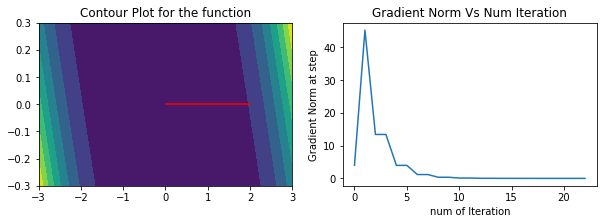

,alpha,xk
0,[[0.5]],"[[2.0], [0.0]]"
1,[[0.0208333]],"[[1.33333331347], [0.0]]"
2,[[-0.0]],"[[1.33333331347], [0.0]]"
3,[[0.0234375]],"[[0.888888955116], [-4.47034835815e-08]]"
4,[[9.06268e-08]],"[[0.888889209717], [-2.99303820839e-07]]"
5,[[0.0527344]],"[[0.592592702596], [-7.29924067855e-08]]"
6,[[8.60244e-08]],"[[0.592592774203], [-1.44598637064e-07]]"
7,[[0.118652]],"[[0.395061729719], [1.09904831902e-08]]"
8,[[1.83726e-07]],"[[0.395061775033], [-3.43228201416e-08]]"
9,[[0.266968]],"[[0.263374521319], [-1.44321692375e-08]]"


In [13]:
x1 = Symbol('x1')
x2 = Symbol('x2')
f = x2**2 + (x1 + x2)**4
deriv_1 = np.array([f.diff(x1), f.diff(x2)])

Q = np.array([[deriv_1[0].diff(x1),deriv_1[0].diff(x2)],
              [deriv_1[1].diff(x1),deriv_1[1].diff(x2)]])

# Initialize Xk
xk = np.array([2,-2], dtype=float).reshape(2,1)

fx_array, gradientNorm_arr, alpha_arr, xk1_arr= iterate(f, xk, deriv_1, Q,
                                                 numFeatures=2, numSteps=100, should_print=10)
outData = pd.DataFrame(columns=["alpha","xk"])
outData["alpha"] = alpha_arr
outData["xk"] = xk1_arr

###########  Plot  ###########
x1_x2 = np.asarray(xk1_arr)
u = np.linspace(-3,3,5000)
v = np.linspace(-0.3,0.3,5000)
x1,x2 = np.meshgrid(u,v)
z = x2**2 + (x1 + x2)**4
plot([dict(x1=x1, x2=x2, z=z, sol_x1=x1_x2[:,0], sol_x2=x1_x2[:,1]), dict(gradientNorm = gradientNorm_arr)], contour=True)

outData

# Solution d(5)

## a)

4*x1*(x1**2 + x2**2 - 0.25) + 2*x1 - 2
4*x2*(x1**2 + x2**2 - 0.25) + 2*x2 - 2
Check if the vector d is Q conjugate or not [[  5.34057617e-05]]
Check if the vector d is Q conjugate or not [[ 0.]]
Check if the vector d is Q conjugate or not [[ -2.86102295e-06]]
Check if the vector d is Q conjugate or not [[ -9.53674316e-07]]
Check if the vector d is Q conjugate or not [[ -2.38418579e-07]]
Check if the vector d is Q conjugate or not [[ 0.]]
Check if the vector d is Q conjugate or not [[  3.72529030e-09]]
Check if the vector d is Q conjugate or not [[ 0.]]
Check if the vector d is Q conjugate or not [[ 0.]]

##########################################################
Function F at x: f(x)  0.529336196769008
Gradient at xk9 is:  [  9.76701776e-05   1.05066996e-04]
####### Gradient Norm:  0.000143452
The updated Value dk10 is 
 [[ -9.02411193e-05]
 [ -1.11885587e-04]]
The updated Value xk10 is 
 [[ 0.56409764]
 [ 0.56409973]]
Check if the vector d is Q conjugate or not [[ 0.]]
The check (grad

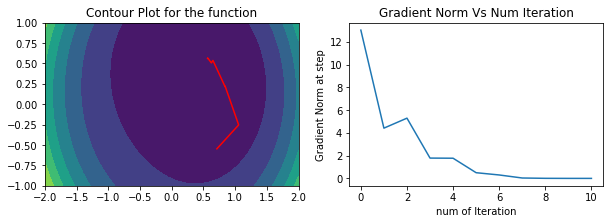

,alpha,xk
0,[[0.0412421]],"[[0.711305], [-0.546337]]"
1,[[0.304631]],"[[1.05484], [-0.2537]]"
2,[[0.0952857]],"[[0.842361], [0.220259]]"
3,[[0.00447245]],"[[0.839756], [0.217108]]"
4,[[0.197869]],"[[0.649439], [0.537568]]"
5,[[0.0803025]],"[[0.624478], [0.507269]]"
6,[[0.270595]],"[[0.567609], [0.566041]]"
7,[[0.112435]],"[[0.565214], [0.563075]]"
8,[[0.279614]],"[[0.564098], [0.5641]]"
9,[[0.116038]],"[[0.564087], [0.564087]]"


In [18]:
x1 = Symbol('x1')
x2 = Symbol('x2')
f = (x1-1)**2 + (x2-1)**2 + (x1**2 + x2**2 -0.25)**2
deriv_1 = np.array([f.diff(x1), f.diff(x2)])
print(deriv_1[0])
print(deriv_1[1])
Q = np.array([[deriv_1[0].diff(x1),deriv_1[0].diff(x2)],
              [deriv_1[1].diff(x1),deriv_1[1].diff(x2)]])
# Initialize Xk
xk = np.array([1,-1], dtype='float32').reshape(2,1)
 
fx_array, gradientNorm_arr, alpha_arr, xk1_arr= iterate(f, xk, deriv_1, Q,
                                                 numFeatures=2, numSteps=100, should_print=10)

outData = pd.DataFrame(columns=["alpha","xk"])
outData["alpha"] = alpha_arr
outData["xk"] = xk1_arr

###########  Plot  ###########
x1_x2 = np.asarray(xk1_arr)
u = np.linspace(-2,2,5000)
v = np.linspace(-1,1,5000)
x1,x2 = np.meshgrid(u,v)
z = (x1-1)**2 + (x2-1)**2 + (x1**2 + x2**2 -0.25)**2
plot([dict(x1=x1, x2=x2, z=z, sol_x1=x1_x2[:,0], sol_x2=x1_x2[:,1]), dict(gradientNorm = gradientNorm_arr)], contour=True)

outData

## b)

40*x1*(x1**2 + x2**2 - 0.25) + 2*x1 - 2
40*x2*(x1**2 + x2**2 - 0.25) + 2*x2 - 2
Check if the vector d is Q conjugate or not [[ 0.03320312]]
Check if the vector d is Q conjugate or not [[ 0.00024414]]
Check if the vector d is Q conjugate or not [[ 0.00134277]]
Check if the vector d is Q conjugate or not [[ 0.]]
Check if the vector d is Q conjugate or not [[  6.48498535e-05]]
Check if the vector d is Q conjugate or not [[ -2.86102295e-06]]
Check if the vector d is Q conjugate or not [[  3.05175781e-05]]
Check if the vector d is Q conjugate or not [[  3.81469727e-06]]
Check if the vector d is Q conjugate or not [[ -1.90734863e-06]]

##########################################################
Function F at x: f(x)  0.793594276250878
Gradient at xk9 is:  [ 1.02806401  0.57645142]
####### Gradient Norm:  1.17865
The updated Value dk10 is 
 [[-0.83194786]
 [-0.9676345 ]]
The updated Value xk10 is 
 [[ 0.45988631]
 [ 0.39129779]]
Check if the vector d is Q conjugate or not [[ -3.57627869e-07]]


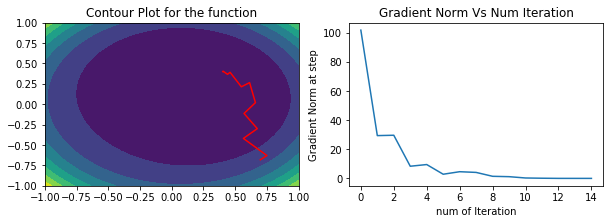

,alpha,xk
0,[[0.00431264]],"[[0.698115], [-0.680865]]"
1,[[0.0445808]],"[[0.750515], [-0.629361]]"
2,[[0.00945839]],"[[0.564692], [-0.418937]]"
3,[[0.146333]],"[[0.674333], [-0.298988]]"
4,[[0.0213288]],"[[0.569806], [-0.112988]]"
5,[[0.483581]],"[[0.659718], [0.0198934]]"
6,[[0.0389393]],"[[0.613637], [0.265095]]"
7,[[0.0178495]],"[[0.5487], [0.214146]]"
8,[[0.144992]],"[[0.459886], [0.391298]]"
9,[[0.024756]],"[[0.439291], [0.367343]]"


In [19]:
x1 = Symbol('x1')
x2 = Symbol('x2')
f = (x1-1)**2 + (x2-1)**2 + 10*(x1**2 + x2**2 -0.25)**2
deriv_1 = np.array([f.diff(x1), f.diff(x2)])
print(deriv_1[0])
print(deriv_1[1])
Q = np.array([[deriv_1[0].diff(x1),deriv_1[0].diff(x2)],
              [deriv_1[1].diff(x1),deriv_1[1].diff(x2)]])
# Initialize Xk
xk = np.array([1,-1], dtype='float32').reshape(2,1)

fx_array, gradientNorm_arr, alpha_arr, xk1_arr= iterate(f, xk, deriv_1, Q,
                                                 numFeatures=2, numSteps=100, should_print=10)
outData = pd.DataFrame(columns=["alpha","xk"])
outData["alpha"] = alpha_arr
outData["xk"] = xk1_arr

###########  Plot  ###########
x1_x2 = np.asarray(xk1_arr)
u = np.linspace(-1,1,5000)
v = np.linspace(-1,1,5000)
x1,x2 = np.meshgrid(u,v)
z = (x1-1)**2 + (x2-1)**2 + 10*(x1**2 + x2**2 -0.25)**2
plot([dict(x1=x1, x2=x2, z=z, sol_x1=x1_x2[:,0], sol_x2=x1_x2[:,1]), dict(gradientNorm = gradientNorm_arr)], contour=True)

outData

## c)

400*x1*(x1**2 + x2**2 - 0.25) + 2*x1 - 2
400*x2*(x1**2 + x2**2 - 0.25) + 2*x2 - 2
Check if the vector d is Q conjugate or not [[ 28.75]]
Check if the vector d is Q conjugate or not [[ 0.015625]]
Check if the vector d is Q conjugate or not [[ 0.99609375]]
Check if the vector d is Q conjugate or not [[ 0.00195312]]
Check if the vector d is Q conjugate or not [[-0.02197266]]
Check if the vector d is Q conjugate or not [[ 0.]]
Check if the vector d is Q conjugate or not [[ 0.00048828]]
Check if the vector d is Q conjugate or not [[ 0.00024414]]
Check if the vector d is Q conjugate or not [[-0.015625]]

##########################################################
Function F at x: f(x)  2.59562839763478
Gradient at xk9 is:  [ 25.00515938  -6.96356201]
####### Gradient Norm:  25.9567
The updated Value dk10 is 
 [[-16.33825302]
 [ 33.49811935]]
The updated Value xk10 is 
 [[ 0.58969504]
 [-0.10838625]]
Check if the vector d is Q conjugate or not [[-0.00097656]]
Check if the vector d is Q conjuga

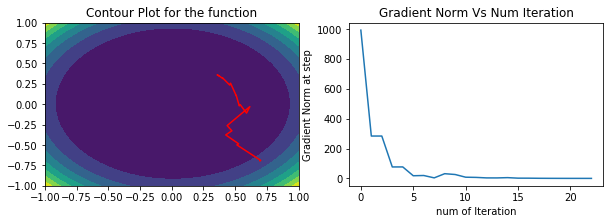

,alpha,xk
0,[[0.000434407]],"[[0.695915], [-0.694177]]"
1,[[0.00463913]],"[[0.701385], [-0.688716]]"
2,[[0.000942178]],"[[0.513685], [-0.498553]]"
3,[[0.0162195]],"[[0.527207], [-0.484898]]"
4,[[0.00193753]],"[[0.425598], [-0.376193]]"
5,[[0.0609932]],"[[0.473906], [-0.325294]]"
6,[[0.00366853]],"[[0.436706], [-0.26154]]"
7,[[0.201432]],"[[0.615703], [-0.028761]]"
8,[[-0.00103715]],"[[0.589695], [-0.108386]]"
9,[[0.00314015]],"[[0.53839], [-0.00319712]]"


In [20]:
x1 = Symbol('x1')
x2 = Symbol('x2')
f = (x1-1)**2 + (x2-1)**2 + 100*(x1**2 + x2**2 -0.25)**2
deriv_1 = np.array([f.diff(x1), f.diff(x2)])
print(deriv_1[0])
print(deriv_1[1])

Q = np.array([[deriv_1[0].diff(x1),deriv_1[0].diff(x2)],
              [deriv_1[1].diff(x1),deriv_1[1].diff(x2)]])
# Initialize Xk
xk = np.array([1,-1], dtype='float32').reshape(2,1)

fx_array, gradientNorm_arr, alpha_arr, xk1_arr= iterate(f, xk, deriv_1, Q,
                                                 numFeatures=2, numSteps=100, should_print=10)
outData = pd.DataFrame(columns=["alpha","xk"])
outData["alpha"] = alpha_arr
outData["xk"] = xk1_arr

###########  Plot  ###########
x1_x2 = np.asarray(xk1_arr)
u = np.linspace(-1,1,5000)
v = np.linspace(-1,1,5000)
x1,x2 = np.meshgrid(u,v)
z = (x1-1)**2 + (x2-1)**2 + 100*(x1**2 + x2**2 -0.25)**2
plot([dict(x1=x1, x2=x2, z=z, sol_x1=x1_x2[:,0], sol_x2=x1_x2[:,1]), dict(gradientNorm = gradientNorm_arr)], contour=True)

outData

In [25]:
from scipy.optimize import linesearch
import scipy as sp
import scipy.optimize
epsilon = 10e-5

# class SetFunction()
#     def __init__(self):
#         self.fnc = 
def function3(x):
#     print(x)
    return 100*pow(x[1]-pow(x[0],2),2) + pow(1-x[1],2)

def objective3(x):
#     print(x)
    a = -400*x[0]*(-x[0]**2 + x[1]) + 2*x[1] - 2
    b = -200*x[0]**2 + 200*x[1]
    return [a,b]


def function4(x):
#     print(x)
    return 100*pow(x[1]-pow(x[0],2),2) + pow(1-x[1],2)

def objective4(x):
#     print(x)
    a = -400*x[0]*(-x[0]**2 + x[1]) + 2*x[1] - 2
    b = -200*x[0]**2 + 200*x[1]
    return [a,b]

In [26]:



def iterateNonQuadratic(f, xk, deriv_1, funciton, objective, numFeature, numSteps, should_print):
    fx_arr = []
    gradientNorm_arr = []
    alpha_arr = []
    for step in range(numSteps):
        print('stepstepstep ', step)
        # Solve for gradient
        fx = f.evalf(subs={x1:xk[0], x2:xk[1]})
        fx_arr.append(fx)
        gradient_xk = np.array([eq.evalf(subs={x1:xk[0], x2:xk[1]}) for eq in deriv_1], dtype='float32')
        gradientNorm = np.linalg.norm(gradient_xk)
        gradientNorm_arr.append(np.linalg.norm(gradientNorm))
        if np.sum((gradientNorm/(1+np.abs(gradient_xk))) <= epsilon) == len(gradient_xk) or (step == 1000):
            print('The check (gradient norm equation reach a val < epsilon, HENCE BREAKING OUT OF LOOP)')
            break
#         print()

        pk = -1 * gradient_xk
        a = linesearch.line_search_wolfe2(function,objective,xk,pk)
        print(a)
        if not a[0]:
            alpha = float(alpha_arr[len(alpha_arr)-1]/2)
#             alpha = 0.01
        else:
            alpha_arr.append(a[0])
            alpha = alpha_arr[len(alpha_arr)-1]

        xk1 = xk - (alpha*gradient_xk)
        print('aaaaaa ', a[0], a)
#
        xk = xk1
        
    return fx_arr, gradientNorm_arr

In [28]:
x1 = Symbol('x1')
x2 = Symbol('x2')
f = 100*pow(x2-pow(x1,2),2) + pow(1-x1,2)
deriv_1 = np.array([f.diff(x1), f.diff(x2)])
print(deriv_1[0])
print(deriv_1[1])

# Initialize Xk
xk = np.array([-1.2,1], dtype='float32')

fx_array, gradientNorm_arr = iterateNonQuadratic(f, xk, deriv_1, 
                                                 function4, objective4,
                                                 numFeature=2, numSteps=10, should_print=1)  
plot([fx_array, gradientNorm_arr])

-400*x1*(-x1**2 + x2) + 2*x1 - 2
-200*x1**2 + 200*x2
stepstepstep  0
(0.00091722178048143769, 11, 1, 0.58741103959519003, 19.360010070802293, [30.716548311490072, 15.243307274610629])
aaaaaa  0.000917221780481 (0.00091722178048143769, 11, 1, 0.58741103959519003, 19.360010070802293, [30.716548311490072, 15.243307274610629])
stepstepstep  1
(0.00096827509435541497, 9, 1, 0.01293196113899988, 0.58741103959519003, [3.9410171798350788, 1.8527583099853473])
aaaaaa  0.000968275094355 (0.00096827509435541497, 9, 1, 0.01293196113899988, 0.58741103959519003, [3.9410171798350788, 1.8527583099853473])
stepstepstep  2
(0.0067990707499102788, 7, 1, 0.0028484533409359283, 0.01293196113899988, [0.15338823565591886, 0.022737835558928055])
aaaaaa  0.00679907074991 (0.0067990707499102788, 7, 1, 0.0028484533409359283, 0.01293196113899988, [0.15338823565591886, 0.022737835558928055])
stepstepstep  3
(None, 13, 0, None, 0.0028484533409359283, None)
aaaaaa  None (None, 13, 0, None, 0.0028484533409359283, Non

/Users/sam/App-Setup/anaconda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


NameError: name 'plot' is not defined